#DTSA 5509 Introduction to Machine Learning: Supervised Learning - Final Project

Github: https://github.com/tkdev001/suumo_ml

##1. Introduction

The major motivation of this project is to apply supervised machine learning techniques to find out bargain rental properties in Tokyo's 23 wards.


Linear regression model and random forest regressor will be used in this project. After model training and evaluation. the model with better performance will be used to calculate the predicted rent. Bargain properties are considered as those with actual rent lower than the predicted rent.

Some major tasks of this project including:

*   Collect property data with web scraping technique (technical detail not included in this notebook)
*   Data wrangling
*   Exploratory data analysis
*   Model fitting & evaluation
*   Apply the chosen model to locate some bargain properties

For hypothesis testing in this project, the significance level α will be set at 0.05.

##2. Data preparation & cleaning

Data has been scraped from SUUMO (https://suumo.jp), one of the largest real estate sites in Japan, on 2nd Dec 2022, with below criteria: \
*   Type: Rental mansion
*   Area: Tokyo 23 wards

(Note that in Japan, "mansion" has a similar meaning as "apartment".)

The raw dataset contains below columns:

*   `name`: name of the building
*   `category`: property type (rental mansion only for this dataset)
*   `address`
*   `access1-3`: closest train station and time needed to reach the station (access1 is the closest one among the 3)
*   `building_age`: in year
*   `structure`: number of floors of the building
*   `floor`: which floor is the property located
*   `rent`: monthly rent in 10K JPY
*   `management_fee`: monthly fee in JPY
*   `deposit`: in 10K JPY
*   `gift`: in 10K JPY (a one-off payment to the owner)
*   `layout`: number of rooms, living rooms, dining rooms, kitchens, storage rooms
*   `area`: in meter square
*   `url`

Summary of the final dataset will be provided at the end of this section. \

All the data collected will only be used within this academic project.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import glob
import os
import itertools
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_rows', 101)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 60)

###1. Import raw data


In [2]:
folder = "/content/drive/MyDrive/raw/suumo/20221202/"

all_files = glob.glob(os.path.join(folder, "*.json"))

df_list = []

for fi in all_files:
  js = []
  with open(fi, encoding="utf-8") as f:
    for li in f:
      js.append(json.loads(li))
  df_list.append(pd.json_normalize(js, record_path=["items"], 
                                   meta=["name", "category", "address", "access1", 
                                         "access2", "access3", "building_age",  "structure"]))

df = pd.concat(df_list, ignore_index=True)
cols = df.columns.tolist()
cols = cols[-8:] + cols[:-8]
df = df[cols]


In [3]:
print(df.shape)
df.tail()

(207455, 16)


,name,category,address,access1,access2,access3,building_age,structure,floor,rent,management_fee,deposit,gift,layout,area,url
207450,ノーブルハウス,賃貸マンション,東京都板橋区赤塚８,東武東上線/下赤塚駅 歩16分,都営三田線/新高島平駅 歩18分,東京メトロ有楽町線/地下鉄赤塚駅 歩18分,築39年,2階建,1階,4.6万円,-,4.6万円,-,ワンルーム,15m2,https://suumo.jp/chintai/jnc_000067586430/?bc=100246330270
207451,東武東上線 下赤塚駅 2階建 築39年,賃貸マンション,東京都板橋区赤塚８,東武東上線/下赤塚駅 歩16分,都営三田線/新高島平駅 歩18分,東京メトロ有楽町線/地下鉄赤塚駅 歩18分,築39年,2階建,1階,4.6万円,-,4.6万円,-,ワンルーム,15m2,https://suumo.jp/chintai/jnc_000067586431/?bc=100291212967
207452,第２サンコート,賃貸マンション,東京都板橋区徳丸６,東武東上線/東武練馬駅 歩23分,都営三田線/高島平駅 歩16分,都営三田線/西台駅 歩19分,築30年,4階建,2階,5.2万円,3000円,5.2万円,5.2万円,1K,22.6m2,https://suumo.jp/chintai/jnc_000070616477/?bc=100254573194
207453,コーポ中島,賃貸マンション,東京都板橋区蓮沼町,ＪＲ京浜東北線/赤羽駅 歩25分,都営三田線/本蓮沼駅 歩5分,都営三田線/板橋本町駅 歩17分,築38年,3階建,3階,5万円,2000円,5万円,-,1K,16.2m2,https://suumo.jp/chintai/jnc_000013504729/?bc=100238997784
207454,ＪＲ京浜東北線 赤羽駅 3階建 築38年,賃貸マンション,東京都板橋区蓮沼町,ＪＲ京浜東北線/赤羽駅 歩25分,都営三田線/本蓮沼駅 歩5分,都営三田線/板橋本町駅 歩17分,築38年,3階建,3階,5万円,2000円,5万円,-,1K,16.2m2,https://suumo.jp/chintai/jnc_000063785806/?bc=100251654220


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207455 entries, 0 to 207454
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            207455 non-null  object
 1   category        207455 non-null  object
 2   address         207455 non-null  object
 3   access1         207455 non-null  object
 4   access2         207455 non-null  object
 5   access3         207455 non-null  object
 6   building_age    207455 non-null  object
 7   structure       207455 non-null  object
 8   floor           207455 non-null  object
 9   rent            207455 non-null  object
 10  management_fee  207455 non-null  object
 11  deposit         207455 non-null  object
 12  gift            207455 non-null  object
 13  layout          207455 non-null  object
 14  area            207455 non-null  object
 15  url             207455 non-null  object
dtypes: object(16)
memory usage: 25.3+ MB


###2. Check for duplicates (by URL)

In [5]:
df["url"].nunique()

207455

No record having the same URL.

###3. Extract ward from address
Extract ward from `address` and store in `ward`.

In [6]:
wards = {"千代田":"Chiyoda",
         "中央":"Chuo",
         "港":"Minato",
         "新宿":"Shinjuku",
         "文京":"Bunkyo",
         "台東":"Taito",
         "墨田":"Sumida",
         "江東":"Koto",
         "品川":"Shinagawa",
         "目黒":"Meguro",
         "大田":"Ota",
         "世田谷":"Setagaya",
         "渋谷":"Shibuya",
         "中野":"Nakano",
         "杉並":"Suginami",
         "豊島":"Toshima",
         "北":"Kita",
         "荒川":"Arakawa",
         "板橋":"Itabashi",
         "練馬":"Nerima",
         "足立":"Adachi",
         "葛飾":"Katsushika",
         "江戸川":"Edogawa"
         }

df["ward"] = df["address"].str.replace("東京都","").str.split("区").str.get(0).map(wards)
df["ward"].unique()

array(['Chiyoda', 'Chuo', 'Minato', 'Shinjuku', 'Bunkyo', 'Shibuya',
       'Taito', 'Sumida', 'Koto', 'Arakawa', 'Adachi', 'Katsushika',
       'Edogawa', 'Shinagawa', 'Meguro', 'Ota', 'Setagaya', 'Nakano',
       'Suginami', 'Nerima', 'Toshima', 'Kita', 'Itabashi'], dtype=object)

In [7]:
print(df.shape)
df[["address", "ward"]].head()

(207455, 17)


,address,ward
0,東京都千代田区神田錦町１,Chiyoda
1,東京都千代田区東神田２,Chiyoda
2,東京都千代田区東神田２,Chiyoda
3,東京都千代田区神田錦町１,Chiyoda
4,東京都千代田区神田錦町１,Chiyoda


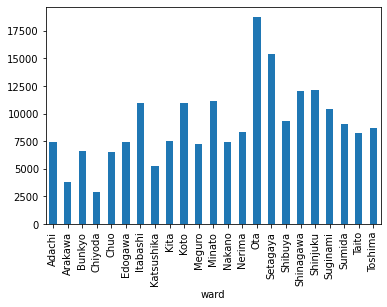

In [8]:
#Record count by ward
df.groupby("ward")["ward"].count().plot.bar()

###4. Nearest station
Extract time needed to walk from the nearest station from `access1` and store in `nearest_station_walk_min`. \
A small amount of properties (around 400 out of 207K) do not have train stations within walking distance (can only reach a station by bus/car). Will remove these properties for simplicity.

In [9]:
sorted(df["access1"].str.split("/").str.get(1).str.split(" ").str.get(1).unique())

['バス10分',
 'バス11分',
 'バス12分',
 'バス13分',
 'バス14分',
 'バス15分',
 'バス16分',
 'バス17分',
 'バス18分',
 'バス19分',
 'バス1分',
 'バス20分',
 'バス21分',
 'バス22分',
 'バス23分',
 'バス24分',
 'バス25分',
 'バス27分',
 'バス33分',
 'バス34分',
 'バス37分',
 'バス3分',
 'バス4分',
 'バス5分',
 'バス6分',
 'バス7分',
 'バス8分',
 'バス9分',
 '歩10分',
 '歩111分',
 '歩11分',
 '歩12分',
 '歩13分',
 '歩14分',
 '歩15分',
 '歩16分',
 '歩17分',
 '歩18分',
 '歩19分',
 '歩1分',
 '歩20分',
 '歩21分',
 '歩22分',
 '歩23分',
 '歩24分',
 '歩25分',
 '歩26分',
 '歩27分',
 '歩28分',
 '歩29分',
 '歩2分',
 '歩30分',
 '歩31分',
 '歩32分',
 '歩33分',
 '歩34分',
 '歩35分',
 '歩36分',
 '歩37分',
 '歩38分',
 '歩3分',
 '歩41分',
 '歩45分',
 '歩48分',
 '歩4分',
 '歩55分',
 '歩5分',
 '歩6分',
 '歩77分',
 '歩7分',
 '歩87分',
 '歩8分',
 '歩9分',
 '車13分(3.1km)',
 '車1分(0.4km)',
 '車7分(2.8km)']

In [10]:
#Only include records with walk time
df = df[df["access1"].str.split("/").str.get(1).str.split(" ").str.get(1).str.contains("歩")]
len(df)

207023

In [11]:
sorted(df["access1"].str.split("/").str.get(1).str.split(" ").str.get(1).unique())

['歩10分',
 '歩111分',
 '歩11分',
 '歩12分',
 '歩13分',
 '歩14分',
 '歩15分',
 '歩16分',
 '歩17分',
 '歩18分',
 '歩19分',
 '歩1分',
 '歩20分',
 '歩21分',
 '歩22分',
 '歩23分',
 '歩24分',
 '歩25分',
 '歩26分',
 '歩27分',
 '歩28分',
 '歩29分',
 '歩2分',
 '歩30分',
 '歩31分',
 '歩32分',
 '歩33分',
 '歩34分',
 '歩35分',
 '歩36分',
 '歩37分',
 '歩38分',
 '歩3分',
 '歩41分',
 '歩45分',
 '歩48分',
 '歩4分',
 '歩55分',
 '歩5分',
 '歩6分',
 '歩77分',
 '歩7分',
 '歩87分',
 '歩8分',
 '歩9分']

In [12]:
df["nearest_station_walk_min"] = df["access1"].str.split("/").str.get(1).str.split(" ").str.get(1).str[1:-1].astype(int)
sorted(df["nearest_station_walk_min"].unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 41,
 45,
 48,
 55,
 77,
 87,
 111]

Remove records with `nearest_station_walk_min` >50 (checked the original web pages and those should be typos.) \
(Alternatively, we can use `access2/3`. Since this only involves very small amount of records, we will just remove them for simplicity.)

In [13]:
df[df["nearest_station_walk_min"]>50]

,name,category,address,access1,access2,access3,building_age,structure,floor,rent,management_fee,deposit,gift,layout,area,url,ward,nearest_station_walk_min
23492,ＪＲ中央線 大久保駅 3階建 築10年,賃貸マンション,東京都新宿区北新宿３,ＪＲ中央線/大久保駅 歩87分,ＪＲ山手線/新大久保駅 歩11分,東京メトロ丸ノ内線/西新宿駅 歩16分,築10年,3階建,2階,8万円,3000円,8万円,8万円,1K,22.44m2,https://suumo.jp/chintai/jnc_000076096220/?bc=100292867909,Shinjuku,87
31450,ハウゼ井上,賃貸マンション,東京都新宿区早稲田鶴巻町,東京メトロ東西線/早稲田駅 歩77分,東京メトロ有楽町線/江戸川橋駅 歩9分,都電荒川線/早稲田駅 歩7分,築35年,5階建,3階,9万円,5000円,9万円,9万円,1DK,30.78m2,https://suumo.jp/chintai/jnc_000070192434/?bc=100283471975,Shinjuku,77
59192,都営大江戸線 両国駅 6階建 築6年,賃貸マンション,東京都墨田区石原２,都営大江戸線/両国駅 歩111分,都営浅草線/本所吾妻橋駅 歩11分,ＪＲ総武線/両国駅 歩10分,築6年,6階建,2階,8.3万円,10000円,-,-,1K,25.55m2,https://suumo.jp/chintai/jnc_000065637873/?bc=100305873702,Sumida,111
59193,都営大江戸線 両国駅 6階建 築6年,賃貸マンション,東京都墨田区石原２,都営大江戸線/両国駅 歩111分,都営浅草線/本所吾妻橋駅 歩11分,ＪＲ総武線/両国駅 歩10分,築6年,6階建,3階,8.5万円,10000円,-,-,1K,25.69m2,https://suumo.jp/chintai/jnc_000078487741/?bc=100306374682,Sumida,111
63457,東京メトロ半蔵門線 押上駅 7階建 築4年,賃貸マンション,東京都墨田区向島３,東京メトロ半蔵門線/押上駅 歩55分,京成押上線/押上駅 歩10分,東武伊勢崎線/とうきょうスカイツリー駅 歩9分,築4年,7階建,6階,8.4万円,15500円,-,-,1K,26.25m2,https://suumo.jp/chintai/jnc_000078487764/?bc=100305956409,Sumida,55


In [14]:
df = df[df["nearest_station_walk_min"]<=50]

print(len(df))

df["nearest_station_walk_min"].describe()

207018


count    207018.000000
mean          6.713580
std           3.876024
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          48.000000
Name: nearest_station_walk_min, dtype: float64

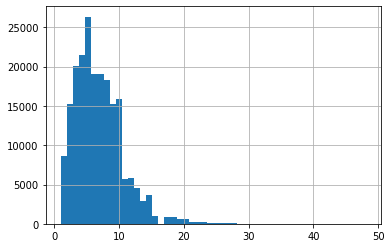

In [15]:
df["nearest_station_walk_min"].hist(bins=50)

###5. Building age
Extract building age from `building_age` and store in `building_age_year`. \
For newly built buildings, assign `building_age_year` with 0.

In [16]:
df["building_age"].unique()

array(['築9年', '築15年', '新築', '築3年', '築8年', '築17年', '築6年', '築21年', '築18年',
       '築11年', '築4年', '築10年', '築7年', '築19年', '築16年', '築20年', '築23年',
       '築5年', '築25年', '築1年', '築52年', '築2年', '築13年', '築12年', '築14年',
       '築54年', '築40年', '築51年', '築22年', '築32年', '築45年', '築26年', '築24年',
       '築44年', '築39年', '築41年', '築46年', '築62年', '築42年', '築43年', '築34年',
       '築61年', '築64年', '築37年', '築38年', '築30年', '築48年', '築50年', '築35年',
       '築36年', '築28年', '築59年', '築33年', '築31年', '築65年', '築53年', '築49年',
       '築27年', '築47年', '築55年', '築58年', '築29年', '築56年', '築57年', '築68年',
       '築60年', '築0年', '築63年', '築66年', '築72年', '築78年', '築69年', '築73年',
       '築79年'], dtype=object)

In [17]:
df["building_age"] = df["building_age"].str.replace("新築","築0年")
df["building_age_year"] = df["building_age"].str[1:-1].astype(int)

df["building_age_year"].describe()

count    207018.000000
mean         19.054324
std          15.034451
min           0.000000
25%           5.000000
50%          18.000000
75%          32.000000
max          79.000000
Name: building_age_year, dtype: float64

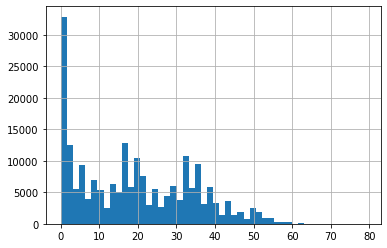

In [18]:
df["building_age_year"].hist(bins=50)

###6. Floor
Rename the original `floor` field to `floor_raw`. \
Extract floor and store in `floor`. \
\
For simplicity, special cases will be handled as:\
For properties with multiple floors, assign with the highest floor. \
For underground floors, assign with negative value. \
Treat mezzanine floor as normal floor.

In [19]:
df = df.rename(columns = {"floor":"floor_raw"})
sorted(df["floor_raw"].unique())

['1-10階',
 '1-11階',
 '1-1階',
 '1-2階',
 '1-3階',
 '1-4階',
 '1-6階',
 '1-7階',
 '1-B1階',
 '10-10階',
 '10-11階',
 '10階',
 '11-12階',
 '11階',
 '12階',
 '13-14階',
 '13階',
 '14階',
 '15-15階',
 '15階',
 '16-17階',
 '16階',
 '17階',
 '18階',
 '19階',
 '1階',
 '2-2階',
 '2-3階',
 '2-4階',
 '2-5階',
 '2-6階',
 '20階',
 '21階',
 '22階',
 '23-24階',
 '23階',
 '24階',
 '25階',
 '26階',
 '27階',
 '28階',
 '29階',
 '2階',
 '3-10階',
 '3-2階',
 '3-3階',
 '3-4階',
 '3-5階',
 '30階',
 '31階',
 '32階',
 '33階',
 '34階',
 '35階',
 '36階',
 '37階',
 '38階',
 '39階',
 '3階',
 '4-3階',
 '4-4階',
 '4-5階',
 '40階',
 '41階',
 '42階',
 '43階',
 '44階',
 '45階',
 '46階',
 '47階',
 '48階',
 '49階',
 '4階',
 '5-5階',
 '5-6階',
 '5-7階',
 '50階',
 '51階',
 '52階',
 '53階',
 '54階',
 '55階',
 '57階',
 '5階',
 '6-7階',
 '6-8階',
 '6階',
 '7-7階',
 '7-8階',
 '7階',
 '8-8階',
 '8-9階',
 '8階',
 '9-10階',
 '9階',
 'B1-1階',
 'B1-2階',
 'B1階',
 'B2-1階',
 'B2階',
 'B3階',
 'B4階',
 'B5階',
 'B6階',
 'B7階',
 'M2階',
 'M3階']

In [20]:
df["floor1"] = df["floor_raw"].str.replace("階","").str.split("-").str.get(0)
df["floor2"] = df["floor_raw"].str.replace("階","").str.split("-").str.get(-1)

df["floor1"] = df["floor1"].str.replace("B","-").str.replace("M","").astype(int)
df["floor2"] = df["floor2"].str.replace("B","-").str.replace("M","").astype(int)

Remove properties with problematic floor info (e.g. multiple floors but small in size) - should be due to typos / lack of information.

In [21]:
df[(abs(df["floor1"]-df["floor2"]) == 3) & (df["layout"].isin(["ワンルーム","1K"]))]

,name,category,address,access1,access2,access3,building_age,structure,floor_raw,rent,management_fee,deposit,gift,layout,area,url,ward,nearest_station_walk_min,building_age_year,floor1,floor2
76268,東京メトロ東西線 木場駅 4階建 築33年,賃貸マンション,東京都江東区東陽５,東京メトロ東西線/木場駅 歩5分,東京メトロ東西線/東陽町駅 歩10分,東京メトロ東西線/門前仲町駅 歩21分,築33年,4階建,1-4階,7.6万円,3000円,7.6万円,-,ワンルーム,29.12m2,https://suumo.jp/chintai/jnc_000024665575/?bc=100288425961,Koto,5,33,1,4
106888,デア・ケーニッヒ,賃貸マンション,東京都品川区西五反田６,東急池上線/戸越銀座駅 歩8分,東急池上線/大崎広小路駅 歩13分,都営浅草線/戸越駅 歩8分,築17年,5階建,1-4階,8万円,5000円,8万円,-,1K,19.17m2,https://suumo.jp/chintai/jnc_000023709940/?bc=100289792957,Shinagawa,8,17,1,4
186182,レジデンスネモト,賃貸マンション,東京都豊島区要町２,東京メトロ有楽町線/千川駅 歩4分,東京メトロ有楽町線/要町駅 歩7分,西武池袋線/椎名町駅 歩15分,築38年,4階建,1-4階,6.3万円,2000円,6.3万円,6.3万円,ワンルーム,15.59m2,https://suumo.jp/chintai/jnc_000050345524/?bc=100246990501,Toshima,4,38,1,4


In [22]:
df = df.drop(df[(abs(df["floor1"]-df["floor2"]) == 3) & (df["layout"].isin(["ワンルーム","1K"]))].index)
print(len(df))

207015


In [23]:
df[abs(df["floor1"]-df["floor2"]) > 3]

,name,category,address,access1,access2,access3,building_age,structure,floor_raw,rent,management_fee,deposit,gift,layout,area,url,ward,nearest_station_walk_min,building_age_year,floor1,floor2
58728,プラウドフラット菊川,賃貸マンション,東京都墨田区立川４,都営新宿線/菊川駅 歩5分,東京メトロ半蔵門線/住吉駅 歩11分,ＪＲ総武線/錦糸町駅 歩15分,築3年,7階建,1-7階,17.7万円,12000円,17.7万円,-,1LDK,40.27m2,https://suumo.jp/chintai/jnc_000078487757/?bc=100294833689,Sumida,5,3,1,7
63046,ルミエール立花,賃貸マンション,東京都墨田区立花３,東武亀戸線/東あずま駅 歩1分,ＪＲ総武線/平井駅 歩14分,ＪＲ総武線/亀戸駅 歩21分,築20年,6階建,2-6階,6.9万円,-,6.9万円,6.9万円,1K,22.03m2,https://suumo.jp/chintai/jnc_000078226208/?bc=100304643463,Sumida,1,20,2,6
66427,コンフォリア森下リバーサイド,賃貸マンション,東京都江東区常盤１,都営大江戸線/森下駅 歩5分,都営大江戸線/清澄白河駅 歩8分,都営新宿線/浜町駅 歩12分,築0年,11階建,1-11階,15.8万円,8000円,15.8万円,-,1LDK,32.28m2,https://suumo.jp/chintai/jnc_000073054856/?bc=100291285221,Koto,5,0,1,11
67440,ディームス東陽町II,賃貸マンション,東京都江東区南砂２,東京メトロ東西線/東陽町駅 歩5分,東京メトロ東西線/南砂町駅 歩10分,ＪＲ京葉線/潮見駅 歩29分,築3年,10階建,1-10階,9.7万円,10000円,9.7万円,9.7万円,1K,25.2m2,https://suumo.jp/chintai/jnc_000078070910/?bc=100304978447,Koto,5,3,1,10
67452,ディームス東陽町II,賃貸マンション,東京都江東区南砂２,東京メトロ東西線/東陽町駅 歩5分,東京メトロ東西線/南砂町駅 歩10分,ＪＲ京葉線/潮見駅 歩29分,築3年,10階建,1-10階,14.7万円,12000円,14.7万円,14.7万円,1LDK,32.76m2,https://suumo.jp/chintai/jnc_000075083690/?bc=100290781655,Koto,5,3,1,10
69360,アーバンテラスエヌ,賃貸マンション,東京都江東区深川１,東京メトロ東西線/門前仲町駅 歩5分,東京メトロ半蔵門線/清澄白河駅 歩10分,ＪＲ京葉線/越中島駅 歩15分,築32年,7階建,1-7階,7.5万円,8000円,7.5万円,-,1DK,28.84m2,https://suumo.jp/chintai/jnc_000075678086/?bc=100290314880,Koto,5,32,1,7
69362,アーバンテラスエヌ,賃貸マンション,東京都江東区深川１,東京メトロ東西線/門前仲町駅 歩5分,東京メトロ半蔵門線/清澄白河駅 歩10分,ＪＲ京葉線/越中島駅 歩15分,築32年,7階建,1-7階,7.6万円,8000円,7.6万円,-,1DK,27.96m2,https://suumo.jp/chintai/jnc_000075678087/?bc=100290314889,Koto,5,32,1,7
86915,エスポワ－ルＫＩＪＩＭＡ,賃貸マンション,東京都足立区栗原３,東武伊勢崎線/西新井駅 歩3分,東武伊勢崎線/梅島駅 歩16分,東武大師線/大師前駅 歩10分,築29年,10階建,3-10階,9.8万円,-,-,-,2DK,46.2m2,https://suumo.jp/chintai/jnc_000055684751/?bc=100304157440,Adachi,3,29,3,10
148864,セブンスターマンション南烏山,賃貸マンション,東京都世田谷区南烏山３,京王線/千歳烏山駅 歩10分,京王線/芦花公園駅 歩7分,京王線/八幡山駅 歩15分,築40年,7階建,1-7階,11万円,3000円,11万円,11万円,3DK,47.28m2,https://suumo.jp/chintai/jnc_000074390385/?bc=100283329701,Setagaya,10,40,1,7
156206,デュオ・スカーラ中野,賃貸マンション,東京都中野区中央５,ＪＲ中央線/中野駅 歩7分,東京メトロ丸ノ内線/新中野駅 歩8分,東京メトロ東西線/中野駅 歩7分,築21年,10階建,1-6階,15万円,10000円,15万円,-,1LDK,45.38m2,https://suumo.jp/chintai/jnc_000078520216/?bc=100306145035,Nakano,7,21,1,6


In [24]:
df = df.drop(df[abs(df["floor1"]-df["floor2"]) > 3].index)
print(len(df))

207005


In [25]:
df["floor"] = df[["floor1","floor2"]].max(axis=1)

df["floor"].describe()

count    207005.000000
mean          4.086109
std           3.468022
min          -7.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          57.000000
Name: floor, dtype: float64

In [26]:
#Check floor_raw -> floor conversion
df1 = df[["floor_raw","floor"]]
df1.drop_duplicates().sort_values("floor_raw")

,floor_raw,floor
37784,1-1階,1
566,1-2階,2
25051,1-3階,3
55601,1-4階,4
10171,1-B1階,1
38178,10-10階,10
4988,10-11階,11
29,10階,10
8897,11-12階,12
66,11階,11


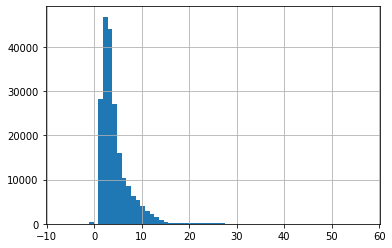

In [27]:
df["floor"].hist(bins=65)

###7. Management fee
Extract from `management_fee`, scale to 10K and store in `management_fee_10k`.

In [28]:
df["management_fee"].str[-2:].unique()

array(['0円', '-', '9円', '1円', '8円', '2円', '4円', '7円', '5円', '3円', '6円'],
      dtype=object)

In [29]:
df["management_fee_10k"] = df["management_fee"].str.replace("-","0").str.replace("円","").astype(float)/10000

df["management_fee_10k"].describe()

count    207005.000000
mean          0.687397
std           0.527354
min           0.000000
25%           0.300000
50%           0.600000
75%           1.000000
max          20.000000
Name: management_fee_10k, dtype: float64

###8. Rent
Extract the rent from `rent`. Store the total of rent and management fee into `rent_total_10k`.

In [30]:
df["rent"].str[-2:].unique()

array(['万円'], dtype=object)

In [31]:
df["rent_10k"] = df["rent"].str[:-2].astype(float)

df["rent_10k"].describe()

count    207005.000000
mean         10.919698
std           8.333399
min           1.700000
25%           7.300000
50%           9.000000
75%          12.000000
max         830.000000
Name: rent_10k, dtype: float64

Remove problematic records with rent > 8000K JPY

In [32]:
df[df["rent_10k"]>800]

,name,category,address,access1,access2,access3,building_age,structure,floor_raw,rent,management_fee,deposit,gift,layout,area,url,ward,nearest_station_walk_min,building_age_year,floor1,floor2,floor,management_fee_10k,rent_10k
141745,京王線 千歳烏山駅 3階建 築42年,賃貸マンション,東京都世田谷区南烏山６,京王線/千歳烏山駅 歩3分,京王線/芦花公園駅 歩13分,京王線/八幡山駅 歩23分,築42年,3階建,2階,830万円,2000円,830万円,830万円,1DK,27.5m2,https://suumo.jp/chintai/jnc_000078554312/?bc=100306331630,Setagaya,3,42,2,2,2,0.2,830.0


In [33]:
df = df[df["rent_10k"]<=800]

df["rent_10k"].describe()

count    207004.000000
mean         10.915741
std           8.136638
min           1.700000
25%           7.300000
50%           9.000000
75%          12.000000
max         350.000000
Name: rent_10k, dtype: float64

In [34]:
df["rent_total_10k"] = df["rent_10k"] + df["management_fee_10k"]

df["rent_total_10k"].describe()

count    207004.000000
mean         11.603141
std           8.257313
min           2.500000
25%           7.800000
50%           9.700000
75%          12.800000
max         350.000000
Name: rent_total_10k, dtype: float64

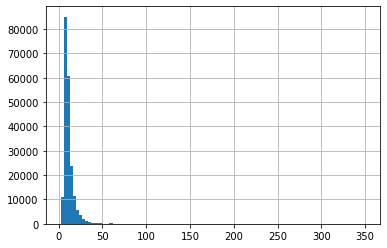

In [35]:
df["rent_total_10k"].hist(bins=100)

###9. Deposit
Extract from `deposit` and store in `deposit_10k`.

In [36]:
df["deposit"].str[-2:].unique()

array(['万円', '-'], dtype=object)

In [37]:
df["deposit_10k"] = df["deposit"].str.replace("-","0").str.replace("万円","").astype(float)

df["deposit_10k"].describe()

count    207004.000000
mean          8.984463
std          21.362715
min           0.000000
25%           0.000000
50%           7.400000
75%          11.000000
max        2666.000000
Name: deposit_10k, dtype: float64

###10. Gift money
Extract from `gift` and store in `gift_10k`.

In [38]:
df["gift"].str[-2:].unique()

array(['万円', '-'], dtype=object)

In [39]:
df["gift_10k"] = df["gift"].str.replace("-","0").str.replace("万円","").astype(float)

df["gift_10k"].describe()

count    207004.000000
mean          6.541338
std           9.413917
min           0.000000
25%           0.000000
50%           6.000000
75%           9.800000
max         361.000000
Name: gift_10k, dtype: float64

###11. Layout
Extract number of bedrooms, living rooms, dining rooms, kitchens, storage rooms from `layout`. \
Note: in Japan, layout of a property is typically notated as something like "2LDK" - which means 2 bedrooms, 1 living room, 1 dining room, and 1 kitchen. Studio apartment is referred as "ワンルーム" (one room).

In [40]:
df["layout"].unique()

array(['2DK', '1K', '1LDK', '2LDK', '1DK', 'ワンルーム', '3LDK', '2SLDK',
       '1SLDK', '1SDK', '3DK', '4LDK', '2K', '2SDK', '3SLDK', '4SLDK',
       '2SK', '1LK', '3K', '1SK', '3SDK', '5LDK', '1SLK', '2LK', '4DK',
       '6LDK', '5K', '11K', '7LDK', '4K', '5DK', '5SLDK', '7SLDK', '3LK',
       '3SK', '4SDK'], dtype=object)

Remove below typo record.

In [41]:
df[df["layout"]=="11K"]

,name,category,address,access1,access2,access3,building_age,structure,floor_raw,rent,management_fee,deposit,gift,layout,area,url,ward,nearest_station_walk_min,building_age_year,floor1,floor2,floor,management_fee_10k,rent_10k,rent_total_10k,deposit_10k,gift_10k
88814,ヴィラージュ柴又,賃貸マンション,東京都葛飾区柴又５,北総線/新柴又駅 歩2分,京成金町線/柴又駅 歩11分,京成本線/京成小岩駅 歩15分,築0年,5階建,1階,7.65万円,5000円,-,7.65万円,11K,25.91m2,https://suumo.jp/chintai/jnc_000077850330/?bc=100300835692,Katsushika,2,0,1,1,1,0.5,7.65,8.15,0.0,7.65


In [42]:
df = df[df["layout"]!="11K"]

print(len(df))

207003


In [43]:
df["room"] = df["layout"].str.replace("ワンルーム","1").str[:1].astype(int)
df["living"] = df["layout"].str.count("L").astype(int)
df["dining"] = df["layout"].str.count("D").astype(int)
df["kitchen"] = df["layout"].str.count("K").astype(int)
df["storage"] = df["layout"].str.count("S").astype(int)

In [44]:
df[["room","living","dining","kitchen","storage"]].describe()

,room,living,dining,kitchen,storage
count,207003.000000,207003.000000,207003.000000,207003.000000,207003.000000
mean,1.182316,0.208915,0.348763,0.816534,0.010459
std,0.460104,0.406534,0.476580,0.387049,0.101732
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000
max,7.000000,1.000000,1.000000,1.000000,1.000000


###12. Area
Extract from `area` and store in `area_m2`.

In [45]:
df["area"].str[-2:].unique()

array(['m2'], dtype=object)

In [46]:
df["area_m2"] = df["area"].str[:-2].astype(float)

df["area_m2"].describe()

count    207003.000000
mean         30.810262
std          15.420754
min           2.000000
25%          21.500000
50%          25.750000
75%          36.310000
max         562.630000
Name: area_m2, dtype: float64

Remove below record with typo.

In [47]:
df[df["area_m2"]<=2]

,name,category,address,access1,access2,access3,building_age,structure,floor_raw,rent,management_fee,deposit,gift,layout,area,url,ward,nearest_station_walk_min,building_age_year,floor1,floor2,floor,management_fee_10k,rent_10k,rent_total_10k,deposit_10k,gift_10k,room,living,dining,kitchen,storage,area_m2
35873,パレステュディオシンシア文京千石,賃貸マンション,東京都文京区千石４,ＪＲ山手線/巣鴨駅 歩7分,都営三田線/千石駅 歩3分,東京メトロ南北線/駒込駅 歩14分,築20年,13階建,7階,7.7万円,15000円,-,-,1K,2m2,https://suumo.jp/chintai/jnc_000062641006/?bc=100304803955,Bunkyo,7,20,7,7,7,1.5,7.7,9.2,0.0,0.0,1,0,0,1,0,2.0


In [48]:
df = df[df["area_m2"]>2]

print(len(df))

207002


Remove below records with unreasonably high rent per unit area.

In [49]:
df[(df["rent_total_10k"]/df["area_m2"]) > 3]

,name,category,address,access1,access2,access3,building_age,structure,floor_raw,rent,management_fee,deposit,gift,layout,area,url,ward,nearest_station_walk_min,building_age_year,floor1,floor2,floor,management_fee_10k,rent_10k,rent_total_10k,deposit_10k,gift_10k,room,living,dining,kitchen,storage,area_m2
31062,ガリシア新宿西落合II(ガリシアシンジュクニシオチアイ),賃貸マンション,東京都新宿区西落合２,都営大江戸線/落合南長崎駅 歩9分,西武新宿線/新井薬師前駅 歩11分,都営大江戸線/中井駅 歩20分,築2年,5階建,1階,88.5万円,16000円,-,-,1K,25.93m2,https://suumo.jp/chintai/jnc_000078404082/?bc=100305541974,Shinjuku,9,2,1,1,1,1.60,88.5,90.10,0.0,0.0,1,0,0,1,0,25.93
57642,都営大江戸線 両国駅 10階建 新築,賃貸マンション,東京都墨田区緑２,都営大江戸線/両国駅 歩7分,都営新宿線/森下駅 歩8分,ＪＲ総武線/両国駅 歩11分,築0年,10階建,8階,95.5万円,10000円,95.5万円,95.5万円,1K,25.39m2,https://suumo.jp/chintai/jnc_000078384847/?bc=100305432254,Sumida,7,0,8,8,8,1.00,95.5,96.50,95.5,95.5,1,0,0,1,0,25.39
58290,アイルラメール錦糸町,賃貸マンション,東京都墨田区太平１,東京メトロ半蔵門線/錦糸町駅 歩10分,ＪＲ総武線/錦糸町駅 歩9分,都営浅草線/本所吾妻橋駅 歩14分,築9年,7階建,4階,88万円,9000円,-,-,1K,26.4m2,https://suumo.jp/chintai/jnc_000078531132/?bc=100306190800,Sumida,10,9,4,4,4,0.90,88.0,88.90,0.0,0.0,1,0,0,1,0,26.40
58292,ＪＲ総武線 錦糸町駅 7階建 築9年,賃貸マンション,東京都墨田区太平１,ＪＲ総武線/錦糸町駅 歩9分,東京メトロ半蔵門線/錦糸町駅 歩9分,東武伊勢崎線/とうきょうスカイツリー駅 歩13分,築9年,7階建,4階,88万円,9000円,-,-,1K,26.4m2,https://suumo.jp/chintai/jnc_000078553762/?bc=100306321579,Sumida,9,9,4,4,4,0.90,88.0,88.90,0.0,0.0,1,0,0,1,0,26.40
59719,レオパレス京島,賃貸マンション,東京都墨田区京島３,京成押上線/京成曳舟駅 歩10分,東武亀戸線/小村井駅 歩10分,東武伊勢崎線/曳舟駅 歩14分,築19年,3階建,1階,77万円,5500円,-,77万円,1K,19.87m2,https://suumo.jp/chintai/jnc_000078380909/?bc=100274784546,Sumida,10,19,1,1,1,0.55,77.0,77.55,0.0,77.0,1,0,0,1,0,19.87
78292,Le-lion Vranche′日暮里East,賃貸マンション,東京都荒川区東日暮里２,東京メトロ日比谷線/三ノ輪駅 歩8分,ＪＲ常磐線/三河島駅 歩11分,ＪＲ山手線/鶯谷駅 歩18分,築17年,7階建,2階,91.5万円,10000円,91.5万円,91.5万円,1K,25.6m2,https://suumo.jp/chintai/jnc_000078444136/?bc=100305749278,Arakawa,8,17,2,2,2,1.00,91.5,92.50,91.5,91.5,1,0,0,1,0,25.60
79632,ＪＲ山手線 日暮里駅 9階建 築9年,賃貸マンション,東京都荒川区東日暮里６,ＪＲ山手線/日暮里駅 歩6分,ＪＲ常磐線/三河島駅 歩10分,ＪＲ山手線/西日暮里駅 歩13分,築9年,9階建,4階,190万円,7000円,190万円,190万円,1DK,25m2,https://suumo.jp/chintai/jnc_000074732241/?bc=100284889350,Arakawa,6,9,4,4,4,0.70,190.0,190.70,190.0,190.0,1,0,1,1,0,25.00
82458,メインステージ北千住III,賃貸マンション,東京都足立区千住寿町,東京メトロ日比谷線/北千住駅 歩9分,京成本線/千住大橋駅 歩18分,東武伊勢崎線/牛田駅 歩23分,築8年,14階建,9階,72.5万円,12000円,-,72.5万円,1K,20.6m2,https://suumo.jp/chintai/jnc_000077964893/?bc=100303474864,Adachi,9,8,9,9,9,1.20,72.5,73.70,0.0,72.5,1,0,0,1,0,20.60
118005,京王井の頭線 神泉駅 4階建 築11年,賃貸マンション,東京都目黒区大橋２,京王井の頭線/神泉駅 歩10分,京王井の頭線/駒場東大前駅 歩10分,東急田園都市線/池尻大橋駅 歩10分,築11年,4階建,3階,15.2万円,5000円,15.2万円,15.2万円,ワンルーム,4.68m2,https://suumo.jp/chintai/jnc_000077420391/?bc=100304652387,Meguro,10,11,3,3,3,0.50,15.2,15.70,15.2,15.2,1,0,0,0,0,4.68
142121,Nasicフローラコート世田谷,賃貸マンション,東京都世田谷区南烏山５,京王線/千歳烏山駅 歩4分,,,築41年,6階建,6階,98.8万円,11000円,98.8万円,15万円,ワンルーム,30m2,https://suumo.jp/chintai/jnc_000078237494/?bc=100304685294,Setagaya,4,41,6,6,6,1.10,98.8,99.90,98.8,15.0,1,0,0,0,0,30.00


In [50]:
df = df[(df["rent_total_10k"]/df["area_m2"]) <= 3]

print(len(df))

206991


In [51]:
df["area_m2"].describe()

count    206991.000000
mean         30.810804
std          15.420900
min           2.600000
25%          21.500000
50%          25.750000
75%          36.320000
max         562.630000
Name: area_m2, dtype: float64

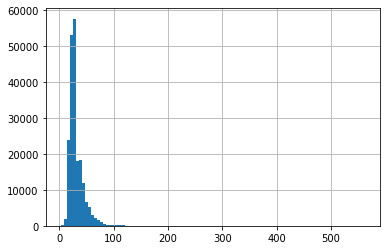

In [52]:
df["area_m2"].hist(bins=100)

###13. Summary
\
Number of rows in the whole dataset: 206,991 \
Dataset will be split into training & testing set in later section. \
\
Response: `rent_total_10k` \
\
Number of (potential) features: 12 (before one-hot encoding) \
List of (potential) features: 

*   `ward` (categorical, the ward which the property located)
*   `building_age_year` (numeric, age of the building in years)
*   `floor` (numeric, which floor is the property located)
*   `nearest_station_walk_min` (numeric, time needed to walk to the nearest train station in min)
*   `area_m2` (numeric, area of the property in meter square)
*   `room` (numeric, number of bedrooms)
*   `living` (numeric, number of living rooms)
*   `dining` (numeric, number of dining rooms)
*   `kitchen` (numeric, number of kitchens)
*   `storage` (numeric, number of storage rooms)
*   `deposit_10k` (numeric, amount of deposit in 10K JPY)
*   `gift_10k` (numeric, amount of one-off gift money to house owner in 10K JPY)

Below columns will not be included in data analysis / modelling:

*   `name` (not relevant to the study)
*   `category` (rental mansions only for this dataset)
*   `access2-3` (drop for simplicity - assume `access1` is sufficient to capture the information)
*   `structure` (drop for simplicity - assume `floor` is sufficient to capture the information)
*   `url` (not used in model fitting, but will be used in later sections for verifying the result)

Filtered out records with below criteria (no. of records removed): 

*   No train station within walking distance stated in `access1` (432)
*   `nearest_station_walk_min` > 50 (5)
*   More than 4 floors (13)
*   Rent > 8000K JPY (1)
*   `layout` = 11K (1)
*   `area_m2` <= 2 (1)
*   Rent per unit area > 3K JPY (11)

Due to time constraints, only basic clean up has been performed. As the data source involves manual data input from various housing agencies, it may include typos and duplicates which cannot be easily located.

In [53]:
df = df.reset_index(drop=True)
df.tail()

,name,category,address,access1,access2,access3,building_age,structure,floor_raw,rent,management_fee,deposit,gift,layout,area,url,ward,nearest_station_walk_min,building_age_year,floor1,floor2,floor,management_fee_10k,rent_10k,rent_total_10k,deposit_10k,gift_10k,room,living,dining,kitchen,storage,area_m2
206986,ノーブルハウス,賃貸マンション,東京都板橋区赤塚８,東武東上線/下赤塚駅 歩16分,都営三田線/新高島平駅 歩18分,東京メトロ有楽町線/地下鉄赤塚駅 歩18分,築39年,2階建,1階,4.6万円,-,4.6万円,-,ワンルーム,15m2,https://suumo.jp/chintai/jnc_000067586430/?bc=100246330270,Itabashi,16,39,1,1,1,0.0,4.6,4.6,4.6,0.0,1,0,0,0,0,15.0
206987,東武東上線 下赤塚駅 2階建 築39年,賃貸マンション,東京都板橋区赤塚８,東武東上線/下赤塚駅 歩16分,都営三田線/新高島平駅 歩18分,東京メトロ有楽町線/地下鉄赤塚駅 歩18分,築39年,2階建,1階,4.6万円,-,4.6万円,-,ワンルーム,15m2,https://suumo.jp/chintai/jnc_000067586431/?bc=100291212967,Itabashi,16,39,1,1,1,0.0,4.6,4.6,4.6,0.0,1,0,0,0,0,15.0
206988,第２サンコート,賃貸マンション,東京都板橋区徳丸６,東武東上線/東武練馬駅 歩23分,都営三田線/高島平駅 歩16分,都営三田線/西台駅 歩19分,築30年,4階建,2階,5.2万円,3000円,5.2万円,5.2万円,1K,22.6m2,https://suumo.jp/chintai/jnc_000070616477/?bc=100254573194,Itabashi,23,30,2,2,2,0.3,5.2,5.5,5.2,5.2,1,0,0,1,0,22.6
206989,コーポ中島,賃貸マンション,東京都板橋区蓮沼町,ＪＲ京浜東北線/赤羽駅 歩25分,都営三田線/本蓮沼駅 歩5分,都営三田線/板橋本町駅 歩17分,築38年,3階建,3階,5万円,2000円,5万円,-,1K,16.2m2,https://suumo.jp/chintai/jnc_000013504729/?bc=100238997784,Itabashi,25,38,3,3,3,0.2,5.0,5.2,5.0,0.0,1,0,0,1,0,16.2
206990,ＪＲ京浜東北線 赤羽駅 3階建 築38年,賃貸マンション,東京都板橋区蓮沼町,ＪＲ京浜東北線/赤羽駅 歩25分,都営三田線/本蓮沼駅 歩5分,都営三田線/板橋本町駅 歩17分,築38年,3階建,3階,5万円,2000円,5万円,-,1K,16.2m2,https://suumo.jp/chintai/jnc_000063785806/?bc=100251654220,Itabashi,25,38,3,3,3,0.2,5.0,5.2,5.0,0.0,1,0,0,1,0,16.2


In [54]:
df_cleaned = df[["rent_total_10k",
                 "ward", "building_age_year", "floor", "nearest_station_walk_min", 
                 "area_m2", "room", "living", "dining", "kitchen", "storage",
                 "deposit_10k", "gift_10k", 
                 "url"]]

In [55]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206991 entries, 0 to 206990
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   rent_total_10k            206991 non-null  float64
 1   ward                      206991 non-null  object 
 2   building_age_year         206991 non-null  int64  
 3   floor                     206991 non-null  int64  
 4   nearest_station_walk_min  206991 non-null  int64  
 5   area_m2                   206991 non-null  float64
 6   room                      206991 non-null  int64  
 7   living                    206991 non-null  int64  
 8   dining                    206991 non-null  int64  
 9   kitchen                   206991 non-null  int64  
 10  storage                   206991 non-null  int64  
 11  deposit_10k               206991 non-null  float64
 12  gift_10k                  206991 non-null  float64
 13  url                       206991 non-null  o

##3. Exploratory Data Analysis
Basic checking/visualization of individual columns has been included in above section. This section will include some additional analyses.

###1. Rent (per unit area) in each ward

In [56]:
df_ward = df_cleaned[["rent_total_10k", "ward", "area_m2"]]
df_ward["rent_per_m2"] = df["rent_total_10k"]/df["area_m2"]

#Statistics of rent per unit area of each ward (sort by descending median)
(
    df_ward
 .groupby("ward")['rent_per_m2']
 .agg(["count", "mean", "median", "min", "max"])
 .reset_index()
 .sort_values("median", ascending=False)
 .set_index("ward")
)

<ipython-input-56-864e84e55a14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ward["rent_per_m2"] = df["rent_total_10k"]/df["area_m2"]


,count,mean,median,min,max
ward,,,,,
Minato,11156,0.494781,0.480690,0.099588,1.876791
Chiyoda,2922,0.490019,0.473223,0.225434,1.253831
Shibuya,9313,0.467954,0.458221,0.207469,2.771479
Chuo,6527,0.449104,0.443587,0.039468,1.404255
Shinjuku,12089,0.429673,0.421429,0.165891,1.480698
Shinagawa,12035,0.419156,0.417254,0.178932,2.459971
Meguro,7280,0.424645,0.415945,0.143184,1.089325
Taito,8204,0.405786,0.408320,0.139130,1.466667
Bunkyo,6631,0.394218,0.393482,0.179965,0.938172


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


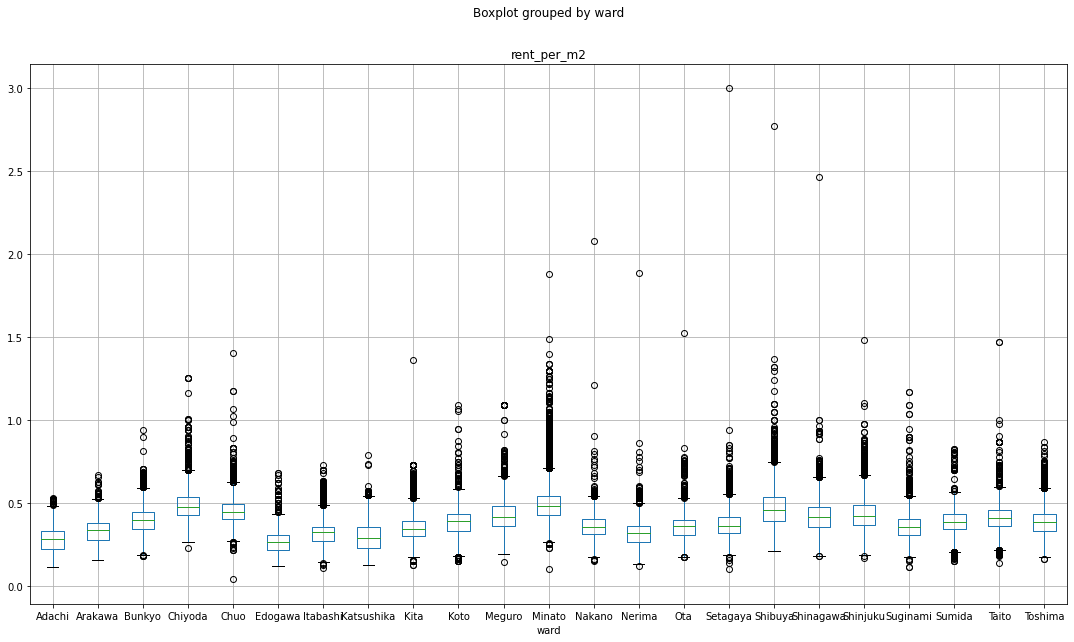

In [57]:
fig, ax = plt.subplots(figsize=(18,10))
df_ward.boxplot(column="rent_per_m2", by="ward", ax=ax)

The statistics show that Minato, Chiyoda, and Shinjuku are some of the wards with highest unit rent. Edogawa, Adachi, and Katsushika have the lowest unit rent. There are significant differences in the rents between different wards. E.g. median of Minato is about 80% higher than that of Edogawa. This is an evidence that `ward` should be considered as a feature.\
The boxplot shows that there are "outliners" in most of the wards. Most of them fall in the upper region. While some of them may due to data issue, this indicates right skewness in the rent figures (also align with histogram in above section). This may pose challenges in model fitting and prediction.

###2. Correlation
Below shows the correlation between the numeric columns.

In [58]:
df_cleaned.corr()

,rent_total_10k,building_age_year,floor,nearest_station_walk_min,area_m2,room,living,dining,kitchen,storage,deposit_10k,gift_10k
rent_total_10k,1.000000,-0.219581,0.358619,-0.062350,0.788633,0.365232,0.523609,0.421448,0.172572,0.153135,0.774877,0.568863
building_age_year,-0.219581,1.000000,-0.148238,0.041854,0.002857,0.210248,-0.108702,0.033682,-0.141671,-0.006678,-0.000733,-0.070656
floor,0.358619,-0.148238,1.000000,-0.129356,0.221528,0.070896,0.181588,0.115827,0.077901,0.040771,0.216662,0.208020
nearest_station_walk_min,-0.062350,0.041854,-0.129356,1.000000,0.053805,0.122104,0.014333,0.060803,0.035845,0.006407,-0.039158,-0.049054
area_m2,0.788633,0.002857,0.221528,0.053805,1.000000,0.662832,0.660909,0.643515,0.277230,0.207158,0.591609,0.538115
room,0.365232,0.210248,0.070896,0.122104,0.662832,1.000000,0.286581,0.414965,0.187832,0.077949,0.270716,0.291388
living,0.523609,-0.108702,0.181588,0.014333,0.660909,0.286581,1.000000,0.701057,0.243598,0.141300,0.293069,0.406855
dining,0.421448,0.033682,0.115827,0.060803,0.643515,0.414965,0.701057,1.000000,0.346893,0.116171,0.242406,0.318031
kitchen,0.172572,-0.141671,0.077901,0.035845,0.277230,0.187832,0.243598,0.346893,1.000000,0.048733,0.072105,0.140987
storage,0.153135,-0.006678,0.040771,0.006407,0.207158,0.077949,0.141300,0.116171,0.048733,1.000000,0.089982,0.123737


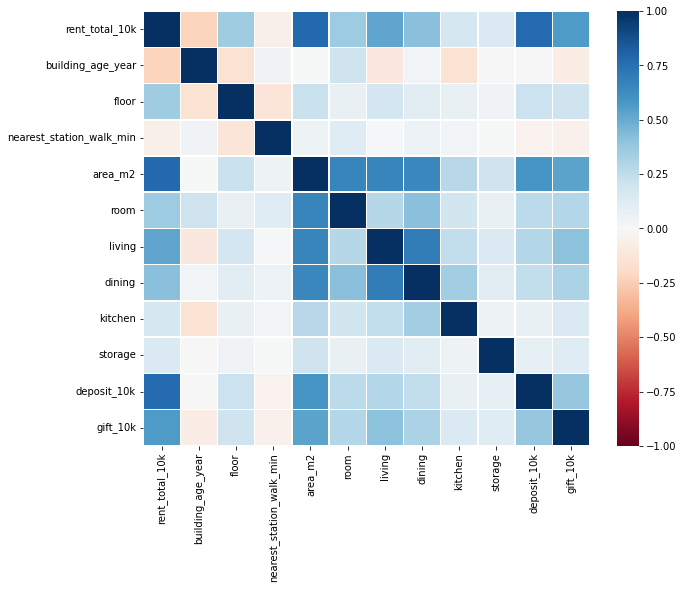

In [59]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_cleaned.corr(), linewidths=.5, ax=ax, vmin=-1,vmax=1, center=0, cmap="RdBu")

On the positive side, area (`area_m2`) and deposit (`deposit_10k`) have the highest correlation with the response (both > 0.77). \
On the negative side, building age (`building_age_year`) is the one having the most negative correlation (around -0.22). \
\
For correlation between features, below feature pairs are notable: \
`area_m2`: `room`, `living`, `dining`, `deposit_10k`, `gift_10k` \
`living`: `dining` 

###3. Summary


*   There is evidence that `ward` should be considered as a feature
*   There is skewness in the data and may pose challenges in model fitting and prediction
*   For numeric features, `area_m2` and `deposit_10k` are some features to be considered first according to correlation. But the correlation between these 2 features are quite high, which should be noted
*   `area_m2` also have high correlation with other potential features including `living`, `dining`


##4. Modelling

###0. Preparation

In [60]:
df_train, df_test = train_test_split(df_cleaned, test_size=0.2, random_state=100)

In [61]:
print(df_train.shape)
print(df_test.shape)

(165592, 14)
(41399, 14)


###1. Linear model

####1. Feature selection

Below code snippet will be used to select the best subsets of features. \

1.   For number of features k=1 to 12, fit a linear model with all the combinations of features
2.   For each k, select the combination with the highest R squared
3.   Among all k=1 to 12, select the optimal k with below criteria:


*   Adjusted R squared (the higher the better)
*   AIC (Akaike information criterion) (the lower the better)
*   BIC (Bayesian information criterion) (the lower the better)

`ward` will be treated as a single feature for now.


In [62]:
def fit_linear_model(y, x, d):
  #Fit linear regression model with y~x on dataframe d
  #Return RSS, R squared, adjusted R squared, AIC, BIC values

  clist = []
  for c in x:
    clist.append(f"C({c})" if d[c].dtype == "object" else c)
  formula = y + "~" + "+".join(clist)

  model = smf.ols(formula=formula, data=d)
  res = model.fit()

  return res.ssr, res.rsquared, res.rsquared_adj, res.aic, res.bic

rss_list, r2_list, r2adj_list, aic_list, bic_list, feature_list, num_features = [], [], [], [], [], [], []
y = df_train.columns[0]
x = df_train.columns[1:-1]

for k in range(1,len(x) + 1):
  for combin in itertools.combinations(x, k):
    iter_result = fit_linear_model(y, list(combin), df_train)
    rss_list.append(iter_result[0])
    r2_list.append(iter_result[1])
    r2adj_list.append(iter_result[2])
    aic_list.append(iter_result[3])
    bic_list.append(iter_result[4])
    feature_list.append(combin)
    num_features.append(len(combin))

lm_fea_sel = pd.DataFrame({"num_features":num_features,"RSS":rss_list, "R_squared":r2_list, "R_squared_adj":r2adj_list, "AIC":aic_list, "BIC":bic_list, "features":feature_list})

In [63]:
lm_fea_sel_r2 = lm_fea_sel[lm_fea_sel.groupby("num_features")["R_squared"].transform(max) == lm_fea_sel["R_squared"]]
lm_fea_sel_r2

,num_features,RSS,R_squared,R_squared_adj,AIC,BIC,features
10,1,4.005514e+06,0.644792,0.644790,997493.333771,997513.368336,"(deposit_10k,)"
55,2,2.411834e+06,0.786119,0.786117,913493.117251,913523.169097,"(area_m2, deposit_10k)"
155,3,1.866103e+06,0.834515,0.834512,871014.928394,871054.997523,"(building_age_year, area_m2, deposit_10k)"
320,4,1.499041e+06,0.867066,0.867045,834789.887181,835050.336519,"(ward, building_age_year, area_m2, deposit_10k)"
806,5,1.411112e+06,0.874863,0.874843,824782.201788,825052.668408,"(ward, building_age_year, floor, area_m2, deposit_10k)"
1633,6,1.346419e+06,0.880600,0.880581,817013.002129,817293.486031,"(ward, building_age_year, floor, area_m2, deposit_10k, g..."
2579,7,1.333915e+06,0.881709,0.881689,815470.076723,815760.577907,"(ward, building_age_year, floor, area_m2, room, deposit_..."
3389,8,1.329803e+06,0.882074,0.882053,814960.761466,815261.279933,"(ward, building_age_year, floor, area_m2, room, kitchen,..."
3814,9,1.327053e+06,0.882317,0.882296,814620.005043,814930.540791,"(ward, building_age_year, floor, nearest_station_walk_mi..."
4024,10,1.326132e+06,0.882399,0.882377,814506.981733,814827.534764,"(ward, building_age_year, floor, nearest_station_walk_mi..."


Adjusted R squared suggested the full model is the best choice, while AIC and BIC suggested k=11. I will start with the full model.

####2. Model fitting (Attempt 1 - full model)

In [64]:
lm_full = smf.ols(formula="rent_total_10k ~ C(ward) + building_age_year + floor + nearest_station_walk_min + area_m2 + room + living + dining + kitchen + storage + deposit_10k + gift_10k", data=df_train).fit()
print(lm_full.summary())

                            OLS Regression Results                            
Dep. Variable:         rent_total_10k   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                 3.767e+04
Date:                Tue, 06 Dec 2022   Prob (F-statistic):               0.00
Time:                        05:21:06   Log-Likelihood:            -4.0718e+05
No. Observations:              165592   AIC:                         8.144e+05
Df Residuals:                  165558   BIC:                         8.148e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Noted from the summary that the p-value of `storage` and dummy feature of Edogawa is high, suggesting the features are statistically insignificant. Also, the summary warned the possibility of multicollinearity according to condition number. We will try to fix this in the following sections.

####3. Multicollinearity

High multicollinearity will increase error when estimating the coefficients. \
Variance inflation factor (VIF) will be used to detect and fix multicollinearity. Following the traditional rule of thumb, a VIF higher than 5 will be used as an indicator of multicollinearity.

First, the categorical feature of `ward` will be encoded using one-hot encoding.

In [65]:
#Expend ward with one-hot encoding
df_train_oh = pd.concat([df_train.iloc[:,0],
                         pd.get_dummies(df_train["ward"], prefix="ward", prefix_sep='_'),
                         df_train.iloc[:,2:]], axis=1)

print(df_train_oh.shape)
df_train_oh.head()

(165592, 36)


,rent_total_10k,ward_Adachi,ward_Arakawa,ward_Bunkyo,ward_Chiyoda,ward_Chuo,ward_Edogawa,ward_Itabashi,ward_Katsushika,ward_Kita,ward_Koto,ward_Meguro,ward_Minato,ward_Nakano,ward_Nerima,ward_Ota,ward_Setagaya,ward_Shibuya,ward_Shinagawa,ward_Shinjuku,ward_Suginami,ward_Sumida,ward_Taito,ward_Toshima,building_age_year,floor,nearest_station_walk_min,area_m2,room,living,dining,kitchen,storage,deposit_10k,gift_10k,url
5077,30.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,22,5,67.44,2,1,1,1,0,30.0,30.0,https://suumo.jp/chintai/jnc_000078561847/?bc=100306343472
121020,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,29,2,7,42.24,1,1,1,1,0,10.0,10.0,https://suumo.jp/chintai/jnc_000078562333/?bc=100306360718
153508,6.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,39,2,2,15.00,1,0,0,0,0,5.9,5.9,https://suumo.jp/chintai/jnc_000069954102/?bc=100299172795
153404,8.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,35,2,15,28.66,1,0,0,1,0,8.0,8.0,https://suumo.jp/chintai/jnc_000073579505/?bc=100295215538
155498,7.5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,31,3,12,13.22,1,0,0,0,0,7.0,7.0,https://suumo.jp/chintai/jnc_000078546569/?bc=100281117067


In [66]:
df_test_oh = pd.concat([df_test.iloc[:,0],
                        pd.get_dummies(df_test["ward"], prefix="ward", prefix_sep='_'),
                        df_test.iloc[:,2:]], axis=1)

print(df_test_oh.shape)
df_test_oh.head()

(41399, 36)


,rent_total_10k,ward_Adachi,ward_Arakawa,ward_Bunkyo,ward_Chiyoda,ward_Chuo,ward_Edogawa,ward_Itabashi,ward_Katsushika,ward_Kita,ward_Koto,ward_Meguro,ward_Minato,ward_Nakano,ward_Nerima,ward_Ota,ward_Setagaya,ward_Shibuya,ward_Shinagawa,ward_Shinjuku,ward_Suginami,ward_Sumida,ward_Taito,ward_Toshima,building_age_year,floor,nearest_station_walk_min,area_m2,room,living,dining,kitchen,storage,deposit_10k,gift_10k,url
157964,6.70,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,29,4,2,17.69,1,0,0,1,0,0.00,0.0,https://suumo.jp/chintai/jnc_000077689117/?bc=100302843954
30101,9.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,17,2,5,25.06,1,0,0,1,0,8.35,16.7,https://suumo.jp/chintai/jnc_000078064734/?bc=100303808401
149620,12.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9,2,10,30.04,1,0,0,1,0,11.90,11.9,https://suumo.jp/chintai/jnc_000076324221/?bc=100303657450
68893,13.80,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,3,26.75,1,0,0,0,0,12.60,0.0,https://suumo.jp/chintai/jnc_000077840082/?bc=100302896404
190606,8.50,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,3,25.65,1,0,0,0,0,0.00,0.0,https://suumo.jp/chintai/jnc_000078164821/?bc=100304325218


In [67]:
def cal_vif(df):
  vif = pd.DataFrame()
  vif["feature"] = df.columns
  vif["vif"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
  
  return vif

In [68]:
#Iteration 1
df_train_oh_dm = add_constant(df_train_oh.iloc[:,1:-1])

cal_vif(df_train_oh_dm)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,vif
0,const,0.000000
1,ward_Adachi,inf
2,ward_Arakawa,inf
3,ward_Bunkyo,inf
4,ward_Chiyoda,inf
5,ward_Chuo,inf
6,ward_Edogawa,inf
7,ward_Itabashi,inf
8,ward_Katsushika,inf
9,ward_Kita,inf


VIF of all dummy variables of `ward` are inf. We will fix this by removing one of the factors, `ward_Edogawa`.

In [69]:
#Iteration 2
df_train_oh_dm = df_train_oh_dm.drop("ward_Edogawa", axis=1)

cal_vif(df_train_oh_dm)

,feature,vif
0,const,51.543997
1,ward_Adachi,1.939203
2,ward_Arakawa,1.509607
3,ward_Bunkyo,1.896361
4,ward_Chiyoda,1.430009
5,ward_Chuo,1.956694
6,ward_Itabashi,2.396142
7,ward_Katsushika,1.673101
8,ward_Kita,1.981746
9,ward_Koto,2.437981


All the dummy variables have a VIF < 5 now. But the VIF of `area_m2` is now higher than 5. Since area is considered as a major feature, instead of removing `area_m2`, we will remove `room`, which is the feature having the highest correlation with `area_m2`.

In [70]:
#Iteration 3
df_train_oh_dm = df_train_oh_dm.drop("room", axis=1)

cal_vif(df_train_oh_dm)

,feature,vif
0,const,50.425417
1,ward_Adachi,1.938747
2,ward_Arakawa,1.509556
3,ward_Bunkyo,1.892335
4,ward_Chiyoda,1.426926
5,ward_Chuo,1.952387
6,ward_Itabashi,2.395104
7,ward_Katsushika,1.673033
8,ward_Kita,1.980548
9,ward_Koto,2.435669


All the features have a VIF below the threshold of 5 now.

####4. Model fitting (Attempt 2 - reduced model)

Now let's fit a model on all features except `ward_Edogawa` and `room`.

In [71]:
lm_re1 = smf.ols(formula="rent_total_10k ~ ward_Adachi + ward_Arakawa + ward_Bunkyo + ward_Chiyoda + ward_Chuo + ward_Itabashi + ward_Katsushika + ward_Kita + ward_Koto + ward_Meguro + ward_Minato + ward_Nakano + ward_Nerima + ward_Ota + ward_Setagaya + ward_Shibuya + ward_Shinagawa + ward_Shinjuku + ward_Suginami + ward_Sumida + ward_Taito + ward_Toshima + building_age_year + floor + nearest_station_walk_min + area_m2 + living + dining + kitchen + storage + deposit_10k + gift_10k", data=df_train_oh).fit()
print(lm_re1.summary())

                            OLS Regression Results                            
Dep. Variable:         rent_total_10k   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                 3.855e+04
Date:                Tue, 06 Dec 2022   Prob (F-statistic):               0.00
Time:                        05:22:06   Log-Likelihood:            -4.0773e+05
No. Observations:              165592   AIC:                         8.155e+05
Df Residuals:                  165559   BIC:                         8.158e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Note that p-value of `storage` and `ward_Adachi` is high. Also the condition number is still high. Let's try to fix this by removing `ward_Adachi` first.

In [72]:
lm_re2 = smf.ols(formula="rent_total_10k ~ ward_Arakawa + ward_Bunkyo + ward_Chiyoda + ward_Chuo + ward_Itabashi + ward_Katsushika + ward_Kita + ward_Koto + ward_Meguro + ward_Minato + ward_Nakano + ward_Nerima + ward_Ota + ward_Setagaya + ward_Shibuya + ward_Shinagawa + ward_Shinjuku + ward_Suginami + ward_Sumida + ward_Taito + ward_Toshima + building_age_year + floor + nearest_station_walk_min + area_m2 + living + dining + kitchen + storage + deposit_10k + gift_10k", data=df_train_oh).fit()
print(lm_re2.summary())

                            OLS Regression Results                            
Dep. Variable:         rent_total_10k   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                 3.980e+04
Date:                Tue, 06 Dec 2022   Prob (F-statistic):               0.00
Time:                        05:22:07   Log-Likelihood:            -4.0773e+05
No. Observations:              165592   AIC:                         8.155e+05
Df Residuals:                  165560   BIC:                         8.158e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

The p-value of `storage` is still high. Let's remove it.

In [73]:
lm_re3 = smf.ols(formula="rent_total_10k ~ ward_Arakawa + ward_Bunkyo + ward_Chiyoda + ward_Chuo + ward_Itabashi + ward_Katsushika + ward_Kita + ward_Koto + ward_Meguro + ward_Minato + ward_Nakano + ward_Nerima + ward_Ota + ward_Setagaya + ward_Shibuya + ward_Shinagawa + ward_Shinjuku + ward_Suginami + ward_Sumida + ward_Taito + ward_Toshima + building_age_year + floor + nearest_station_walk_min + area_m2 + living + dining + kitchen + deposit_10k + gift_10k", data=df_train_oh).fit()
print(lm_re3.summary())

                            OLS Regression Results                            
Dep. Variable:         rent_total_10k   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                 4.112e+04
Date:                Tue, 06 Dec 2022   Prob (F-statistic):               0.00
Time:                        05:22:08   Log-Likelihood:            -4.0773e+05
No. Observations:              165592   AIC:                         8.155e+05
Df Residuals:                  165561   BIC:                         8.158e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Note that for this model:

*   F-test is significant
*   t-test of all the features are significant
*   Standard errors of all the coefficients are acceptable
*   No more warning on high condition number (although it is still over 800 which suggests there may still be multicollinearity to some extent)

Let's verify the VIF for this model.

In [74]:
df_train_oh_dm = df_train_oh_dm.drop(["storage", "ward_Adachi"], axis=1)

cal_vif(df_train_oh_dm)

,feature,vif
0,const,34.972090
1,ward_Arakawa,1.248214
2,ward_Bunkyo,1.447938
3,ward_Chiyoda,1.230178
4,ward_Chuo,1.507389
5,ward_Itabashi,1.678866
6,ward_Katsushika,1.323625
7,ward_Kita,1.480550
8,ward_Koto,1.708881
9,ward_Meguro,1.474609


VIFs of all features are < 5, indicating multicollinearity is at acceptable level. \
This model will be used as the final choice of linear models.

####5. Cross validation

K-fold cross validation with k=3 will be used to compute the R squared and RMSE for the model.

In [75]:
x = df_train_oh.iloc[:,1:-1]
x = x.drop(["ward_Edogawa", "room", "storage", "ward_Adachi"], axis=1)
y = df_train_oh["rent_total_10k"]

lr = LinearRegression()
cv_result_lm = cross_validate(lr, X=x, y=y, cv=3, scoring=["r2", "neg_root_mean_squared_error"])

print(f"R squared: {np.round(np.mean(cv_result_lm['test_r2']),4)}")
print(f"RMSE: {-np.round(np.mean(cv_result_lm['test_neg_root_mean_squared_error']),4)}")

R squared: 0.8812
RMSE: 2.8413


Compute R squared and RMSE of the model on test dataset.

In [76]:
lm_re3_pred = lm_re3.predict(df_test_oh.iloc[:,1:-1])

lm_re3_pred_r2 = r2_score(df_test_oh["rent_total_10k"], lm_re3_pred)
lm_re3_pred_rmse = rmse(df_test_oh["rent_total_10k"], lm_re3_pred)

print(f"R squared on test set: {np.round(lm_re3_pred_r2,4)}")
print(f"RMSE on test set: {np.round(lm_re3_pred_rmse,4)}")

R squared on test set: 0.7993
RMSE on test set: 3.6534


###2. Random forest regressor

In this section, we will try to fit a random forest regressor on the data and perform simple hyperparameter tuning.

####1. First try

In [77]:
#Try with max_depth=5
rfr1 = RandomForestRegressor(max_depth=5, random_state=100)
cv_result_rf1 = cross_validate(rfr1, X=df_train_oh.iloc[:,1:-1], y=df_train_oh["rent_total_10k"], 
                              cv=3, scoring=["r2", "neg_root_mean_squared_error"])

print(f"R squared: {np.round(np.mean(cv_result_rf1['test_r2']),4)}")
print(f"RMSE: {-np.round(np.mean(cv_result_rf1['test_neg_root_mean_squared_error']),4)}")

R squared: 0.8986
RMSE: 2.6223


In [78]:
rfr1.fit(df_train_oh.iloc[:,1:-1], df_train_oh["rent_total_10k"])

rf1_pred = rfr1.predict(df_test_oh.iloc[:,1:-1])

rf1_pred_r2 = r2_score(df_test_oh["rent_total_10k"], rf1_pred)
rf1_pred_rmse = rmse(df_test_oh["rent_total_10k"], rf1_pred)

print(f"R squared on test set: {np.round(rf1_pred_r2,4)}")
print(f"RMSE on test set: {np.round(rf1_pred_rmse,4)}")

R squared on test set: 0.8928
RMSE on test set: 2.67


The model is already showing better performance than the linear model out of the box. Let's try to boost the performance by hyperparameter tuning with grid search.

####2. Hyperparameter tuning

In [79]:
paramters = {
    "max_features": ["sqrt"],
    "max_depth": [40,41,42] #pre-search has been done in order to shorten the notebook run time
}

gridsearch = GridSearchCV(
    RandomForestRegressor(random_state=100),
    paramters,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
 ).fit(df_train_oh.iloc[:,1:-1], df_train_oh["rent_total_10k"])

print(gridsearch.best_params_)
print(f"RMSE: {-np.round(gridsearch.best_score_,4)}")

{'max_depth': 41, 'max_features': 'sqrt'}
RMSE: 1.2591


In [80]:
cv_result_rf2 = cross_validate(gridsearch, X=df_train_oh.iloc[:,1:-1], y=df_train_oh["rent_total_10k"], 
                               cv=3, scoring=["r2"])

print(f"R squared: {np.round(np.mean(cv_result_rf2['test_r2']),4)}")

R squared: 0.9769


In [81]:
rf2_pred = gridsearch.predict(df_test_oh.iloc[:,1:-1])

rf2_pred_r2 = r2_score(df_test_oh["rent_total_10k"], rf2_pred)
rf2_pred_rmse = rmse(df_test_oh["rent_total_10k"], rf2_pred)

print(f"R squared on test set: {np.round(rf2_pred_r2,4)}")
print(f"RMSE on test set: {np.round(rf2_pred_rmse,4)}")

R squared on test set: 0.9797
RMSE on test set: 1.1606


With max_features=sqrt and max_depth=41, the random forest regressor produced a much better performance than the linear model.

###3. Summary

The result of the modelling process will be summarized in the next section. Below is a summary on the tasks and techniques used in this sections.


*   Basic feature engineering - one-hot encoding on `ward`
*   Fitted linear models and random forest regressor models on training data 
*   Selected features of linear model with best subset, adjusted R squared, AIC, BIC, t-test
*   Addressed multicollinearity for linear model using VIF
*   Tuned hyperparameter of random forest regressor with GridSearchCV
*   Evaluated the performance of the models using k-fold cross-validation with R squared and RMSE



##5. Results and Analysis

###1. Summary of the final models

####1. Linear regression model

In [82]:
print(lm_re3.summary())

                            OLS Regression Results                            
Dep. Variable:         rent_total_10k   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                 4.112e+04
Date:                Tue, 06 Dec 2022   Prob (F-statistic):               0.00
Time:                        05:35:01   Log-Likelihood:            -4.0773e+05
No. Observations:              165592   AIC:                         8.155e+05
Df Residuals:                  165561   BIC:                         8.158e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

####2. Random forest regressor


*   max_features: sqrt
*   max_depth: 41
*   Use default for other hyperparameters



###2. Compare the performance of the models

| Metrics | Linear regression | Random forest regressor |
| :- | -: | :-: |
| R squared (3-fold CV) | 0.8812 | 0.9769
| RMSE (3-fold CV) | 2.8413 | 1.2591
| R squared on test set | 0.7993 | 0.9797
| RMSE on test set | 3.6534 | 1.1606


All the metrics showing that the random forest regressor has a better performance the linear regression model. **Random forest regressor will be used** in following analyses and prediction.

###3. Plots

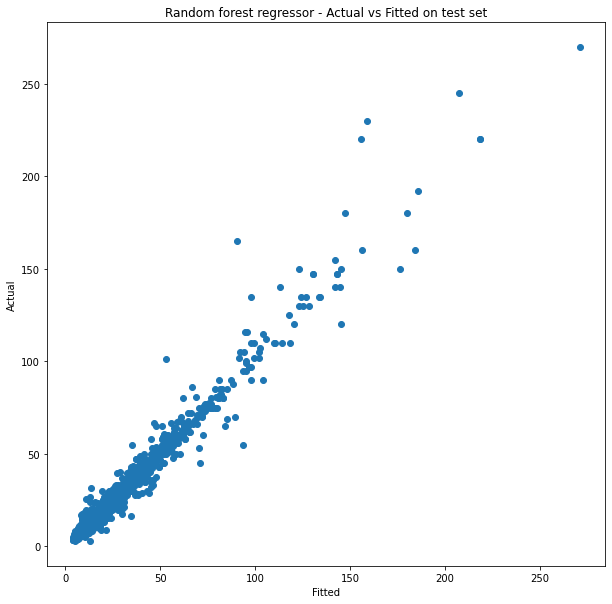

In [83]:
plt.figure(figsize=(10,10))
plt.scatter(rf2_pred, df_test_oh["rent_total_10k"])
plt.title("Random forest regressor - Actual vs Fitted on test set")
plt.xlabel("Fitted")
plt.ylabel("Actual")
plt.show()

For actual vs predicted plot, ideally the points should be close to the diagonal line y=x. Overall speaking the prediction performance is quite good.

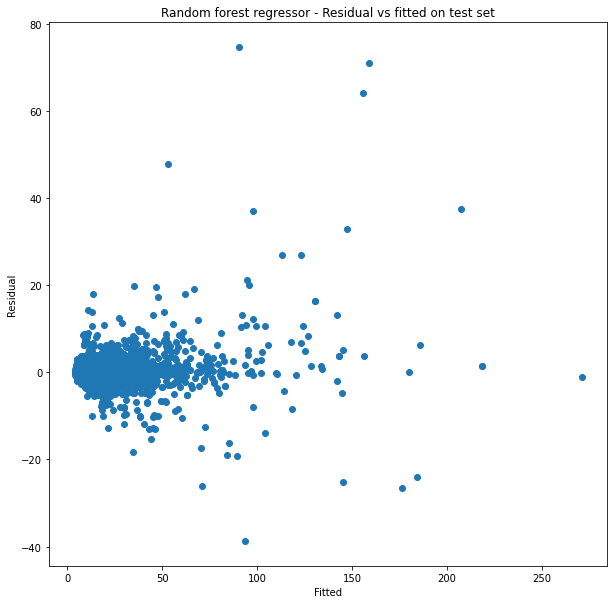

In [84]:
plt.figure(figsize=(10,10))
plt.scatter(rf2_pred, df_test_oh["rent_total_10k"]-rf2_pred)
plt.title("Random forest regressor - Residual vs fitted on test set")
plt.xlabel("Fitted")
plt.ylabel("Residual")
plt.show()

There are some items which the model predicted quite badly, especially in higher rent range. While those may due to data quality issue, it is also possible that the model performs poorly due to lack of data in that price range.

###4. Applying the model to locate bargain properties

Back to our original motivation, let's try to use the model and see if it can discover bargains.

In [85]:
df_apply = df_test.copy()
df_apply["rent_total_10k_pred"] = rf2_pred.tolist()
df_apply["diff"] = df_apply["rent_total_10k"] - df_apply["rent_total_10k_pred"]
df_apply = df_apply.sort_values("diff")[["rent_total_10k", "diff", "ward", "area_m2", "url"]]
df_apply[df_apply["area_m2"].between(25,35)].head(20)

,rent_total_10k,diff,ward,area_m2,url
12071,2.90,-10.049600,Minato,29.12,https://suumo.jp/chintai/jnc_000078567742/?bc=100306409077
119805,5.00,-5.374570,Meguro,34.92,https://suumo.jp/chintai/jnc_000056972906/?bc=100174250940
29521,18.10,-5.007100,Shinjuku,33.04,https://suumo.jp/chintai/jnc_000077476532/?bc=100304126849
29322,13.90,-4.601333,Shinjuku,34.08,https://suumo.jp/chintai/jnc_000076809098/?bc=100297090742
15610,11.30,-4.493000,Minato,33.66,https://suumo.jp/chintai/jnc_000078437740/?bc=100305153989
64964,10.20,-3.975000,Sumida,34.24,https://suumo.jp/chintai/jnc_000024665479/?bc=100303189693
11714,12.00,-3.853000,Minato,33.66,https://suumo.jp/chintai/jnc_000078487595/?bc=100305959514
77749,13.80,-3.782600,Arakawa,30.66,https://suumo.jp/chintai/jnc_000078471807/?bc=100302587671
22825,9.90,-3.600114,Shinjuku,25.33,https://suumo.jp/chintai/jnc_000074502882/?bc=100300125412
11643,11.95,-3.560917,Minato,26.32,https://suumo.jp/chintai/jnc_000077983472/?bc=100303656315


After manual inspection, the result seems reasonable. The model identified some good deals. For example, the monthly rent for below property in Shirokane-takanawa (an area known for high rent) is only 90K JPY, which is very reasonable.

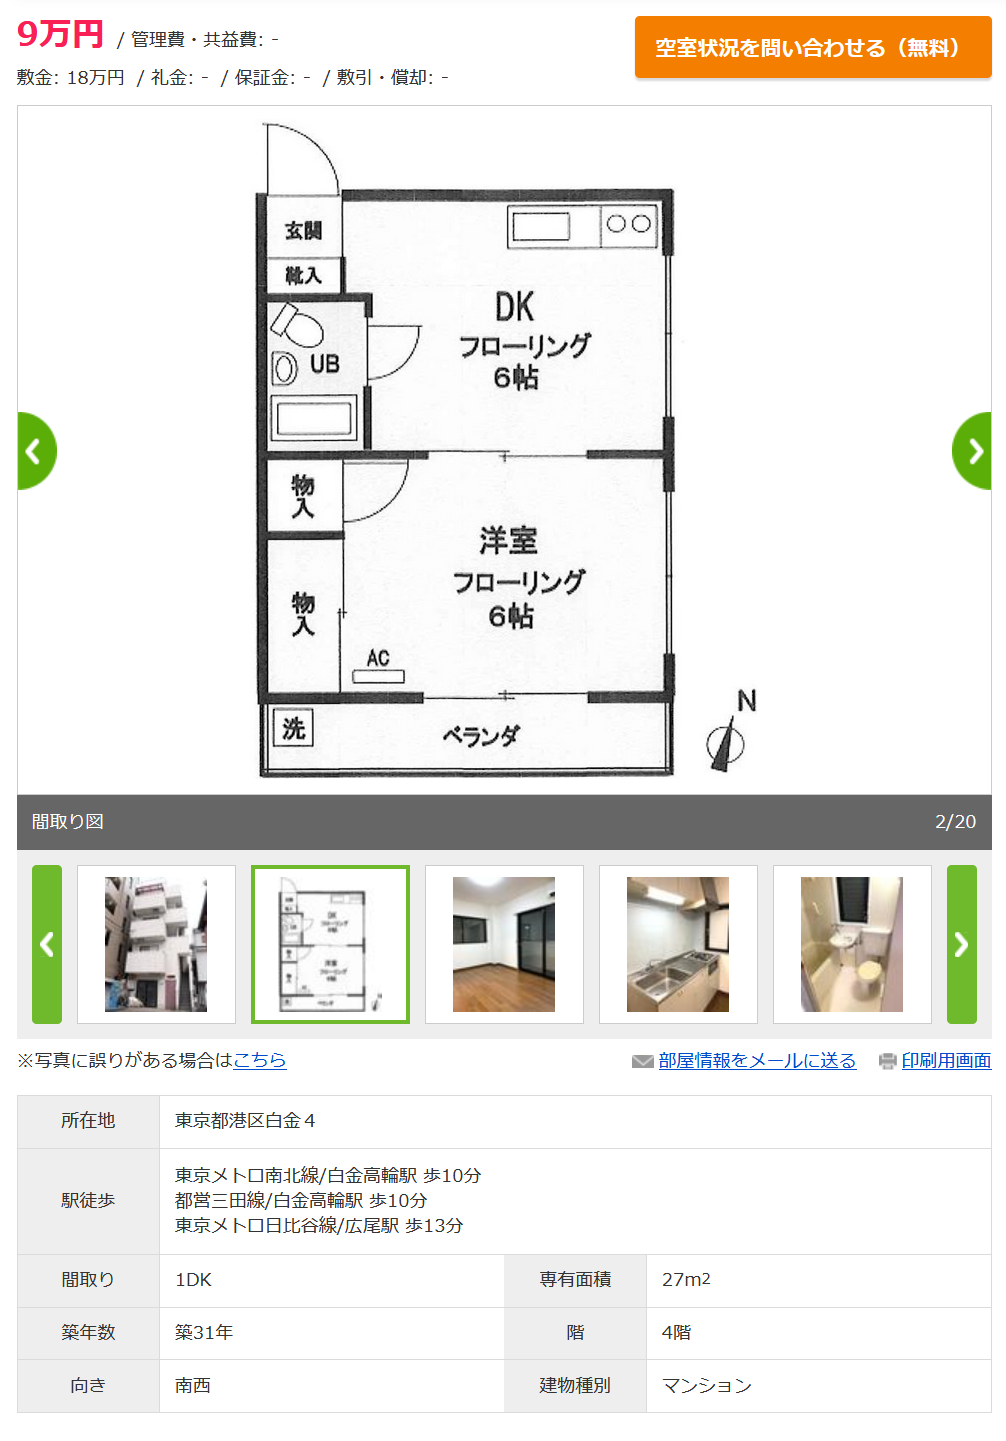

On the other hand, the quality of result is also affected by other factors. For example, features that are not included in the data (like the direction that the property faces), data quality issue, etc.

##5. Discussion and conclusion

After evaluation, I found that the random forest regressor that I trained performs better than the linear regression model. It does not mean that random forest is a better choice over linear regression in general. There are many more improvement that can be made to improve the performance of the linear model. For example, performing more in depth analyses on the relationships between the response and all the features, and apply different kinds of transformation on the features if needed.

While random forest regressor has a better out-of-the-box prediction performance, it also has some drawbacks. It is much harder to analyze and explain the effect of each feature on the response (which is much easier for linear regression model). It also takes longer time to train a model.

Through this project, I was able to put what I have learnt into practice, namely data preparation & wrangling, EDA, model selection, fitting, and evaluation. As a new learner for machine learning, I am surprised by the good performance of random forest. I also recognized the efforts needed for preparing the data.

Some of the ways to improve:

*   More effort on data cleansing. Iterate training with clean data.
*   More in depth analysis and experiment on linear regression model (e.g., feature transformation).
*   More extensive hyperparameter tuning for random forest.
*   Explore the possibility of collecting more data and include as features.
*   Try out other ML models.

